In [46]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F   
import torch.utils.data as data
import torch.optim as optim 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# dataset definition
class load_data(data.Dataset):
    # load the dataset
    def __init__(self, path):
        # store the inputs and outputs
        data = np.load(path)
        self.X = data['X_data']
        self.y = data['y_data']
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [28]:
batch_size = 32

myData = load_data('data.npz')
# Random split
train_set_size = int(len(myData) * 0.8)
test_set_size = len(myData) - train_set_size
train_set, test_set = data.random_split(myData, [train_set_size, test_set_size])

train_data = data.DataLoader(myData, batch_size=batch_size, shuffle=True)
test_data = data.DataLoader(myData, batch_size=test_set_size, shuffle=True)

In [36]:
class Network(nn.Module):
    def __init__(self,input_dim,num_classes,depth=3,width=512):
        super().__init__()

        self.input_dim = input_dim
        self.depth = depth
        self.width = width
        self.output_dim = num_classes

        self.input2hidden = nn.Linear(in_features=input_dim, out_features=width)
        hidden_layers = []
        for i_hlayer in range(depth - 1): 
            hidden_layers.append(nn.Linear(in_features=width, out_features=width))
            hidden_layers.append(nn.GELU())
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.hidden2output = nn.Linear(in_features=width, out_features=self.output_dim)

        self.class_probs = nn.Softmax(dim=1)
        
    def forward(self, z):
        z = self.hidden_layers(F.gelu(self.input2hidden(z)))
        return  self.class_probs(self.hidden2output(z))

In [56]:
net = Network(input_dim=myData.X.shape[1], num_classes=10)
net.train()

# Optimizer and Run options
learning_rate = 0.001 # For optimizer (SGD or Adam)
weight_decay = 1e-5   # For optimizer (SGD or Adam)
optimizer = optim.Adam(params=net.parameters(),
                        lr=learning_rate,
                        weight_decay=weight_decay)

def get_accuracy(model, mydata):
    correct, total = 0, 0
    for[x_batch,y_batch] in mydata:
        x_batch = x_batch.type(torch.float32).to(device)
        zs = model(x_batch)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y_batch.view_as(pred)).sum().item()
        total += int(y_batch.shape[0])
        return correct / total

In [57]:
# Run Options
EPOCHS = 10

losses = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    losses.append(0)

    number_of_batches = 0

    for [x_batch,y_batch] in train_data:
        x_batch = x_batch.type(torch.float32).to(device)

        optimizer.zero_grad()

        class_probs = net(x_batch)

        loss = F.cross_entropy(class_probs,y_batch)

        losses[-1] += loss.item()

        loss.backward()
        optimizer.step()

        number_of_batches += 1

    losses[-1] /= number_of_batches

    train_acc.append(get_accuracy(net, train_data))
    test_acc.append(get_accuracy(net, test_data))

    print("Epoch: {}, Train Loss: {}, Train Acc: {}, Test Acc: {}".format(epoch, losses[-1], train_acc[-1], test_acc[-1]))



Epoch: 0, Train Loss: 2.155032411289215, Train Acc: 0.1875, Test Acc: 0.32725
Epoch: 1, Train Loss: 2.1728289704322816, Train Acc: 0.34375, Test Acc: 0.294625
Epoch: 2, Train Loss: 2.1283970027923584, Train Acc: 0.34375, Test Acc: 0.34425
Epoch: 3, Train Loss: 2.1236505981445313, Train Acc: 0.375, Test Acc: 0.341875
Epoch: 4, Train Loss: 2.123650671482086, Train Acc: 0.25, Test Acc: 0.33025
Epoch: 5, Train Loss: 2.1236555291175843, Train Acc: 0.1875, Test Acc: 0.33925
Epoch: 6, Train Loss: 2.1236511894226076, Train Acc: 0.4375, Test Acc: 0.333125


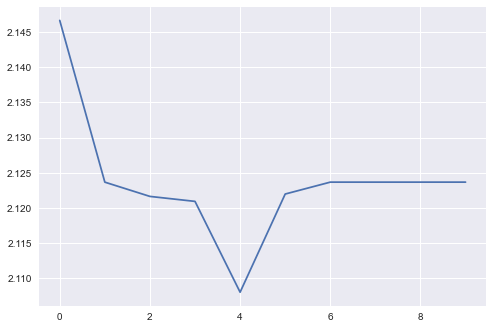

In [47]:
plt.plot(losses)